In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import mylibrary.nnlib as tnn
import copy

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

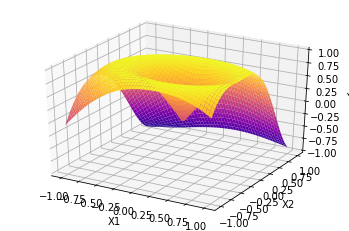

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Training Neural Network

In [4]:
optimizer = tnn.Adam()
net = tnn.AutoForm(new_layers=True)
layer1 = tnn.NonLinearLayer(2, 5, activation=tnn.Relu(), optimizer=optimizer)
layer2 = tnn.NonLinearLayer(5, 5, activation=tnn.Relu(), optimizer=optimizer)
layer3 = tnn.LinearLayer(5, 1, optimizer = optimizer)

In [5]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = net.forward(xx)
    dy = yout - yy
    dx = net.backward(dy)
    net.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  1.8616332378909748


100 Error =  0.03022730127119296


200 Error =  0.0180205665003133


300 Error =  0.014305622559014193


400 Error =  0.011713442590629494


500 Error =  0.010406288524084291


600 Error =  0.009712261072467658


700 Error =  0.009296529168802019


800 Error =  0.009007858526138673


900 Error =  0.007870545095694806


1000 Error =  0.007510784293193421


TclError: invalid command name "pyimage12"

0.007510784293193421


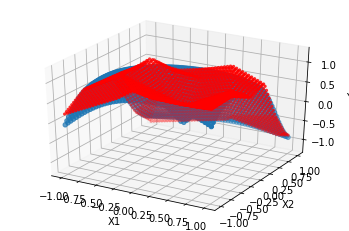

In [6]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('X1');ax.set_ylabel('X2');ax.set_zlabel('Y')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
print(error)

# Sorting the neurons

## Doing this iteratively

In [7]:
n_neurons = [2,5,5,1]
space_D = 1
layers = [layer1, layer2, layer3]

In [8]:
def initialize_positions(layers, n_neurons, space_D):
    positions = []
    for i, neurons in enumerate(n_neurons):
        pos = np.random.uniform(size=(neurons, space_D))
        positions.append(pos)
    return positions

In [9]:
# def normalize_positions(positions):
#     mini, maxi = positions[0].min(), positions[0].max()
#     divisor = maxi-mini

#     for i in range(len(positions)):
#         positions[i] = (positions[i]-mini)/divisor
#     return positions

def normalize_positions(positions):
    mini = 9e9
    maxi = -9e9
    for i in range(len(positions)):
        mi, ma = positions[i].min(), positions[i].max()
        if mi<mini:
            mini=mi
        if ma>maxi:
            maxi=ma
    
    divisor = maxi-mini
    for i in range(len(positions)):
        positions[i] = (positions[i]-mini)/divisor
    return positions

In [10]:
def compute_del_positions_forward(positions, layers):
    del_positions = [0]*len(positions)
    for i, layer in enumerate(layers):
        wts = layer.weights**2
#         scaler0 = wts.sum(axis=1, keepdims=True)
        scaler1 = wts.sum(axis=0, keepdims=True)

#         del_pos0 = positions[i+1].T*wts/scaler0
#         del_pos0 = del_pos0.sum(axis=1, keepdims=True)

        del_pos1 = (positions[i]*wts/scaler1).T
        del_pos1 = del_pos1.sum(axis=1, keepdims=True)
        del_positions[i+1] += del_pos1
        
    del_positions[0] = positions[0]
    return del_positions

def compute_del_positions_backward(positions, layers):
    del_positions = [0]*len(positions)
    for i, layer in enumerate(layers):
        wts = layer.weights**2
        scaler0 = wts.sum(axis=1, keepdims=True)
#         scaler1 = wts.sum(axis=0, keepdims=True)

        del_pos0 = positions[i+1].T*wts/scaler0
        del_pos0 = del_pos0.sum(axis=1, keepdims=True)

#         del_pos1 = (positions[i]*wts/scaler1).T
#         del_pos1 = del_pos1.sum(axis=1, keepdims=True)

        del_positions[i] += del_pos0
        
    del_positions[-1] = positions[-1]
    return del_positions

def compute_del_positions_input(positions, layers):
    layer = layers[0]
    
    wts = layer.weights**2
    scaler0 = wts.sum(axis=1, keepdims=True)

    del_pos0 = positions[1].T*wts/scaler0
    del_pos0 = del_pos0.sum(axis=1, keepdims=True)

    return del_pos0



def compute_del_positions(positions, layers):
    del_positions = [0]*len(positions)
    for i, layer in enumerate(layers):
        wts = layer.weights**2
        scaler0 = wts.sum(axis=1, keepdims=True)
        scaler1 = wts.sum(axis=0, keepdims=True)

        del_pos0 = positions[i+1].T*wts/scaler0
        del_pos0 = del_pos0.sum(axis=1, keepdims=True)

        del_pos1 = (positions[i]*wts/scaler1).T
        del_pos1 = del_pos1.sum(axis=1, keepdims=True)

        del_positions[i] += del_pos0
        del_positions[i+1] += del_pos1
        
#     del_positions[0] = positions[0]
#     del_positions[-1] = positions[-1]
    del_positions[0] = 0.5*del_positions[0] + 0.5*positions[0]
    del_positions[-1] = 0.5*del_positions[-1] + 0.5*positions[-1]
    for i in range(1, len(del_positions)-1):
        del_positions[i] = del_positions[i]/2.    
    return del_positions

Lets start it

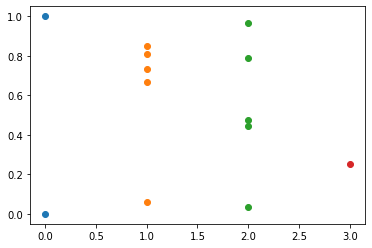

In [11]:
positions = initialize_positions(layers, n_neurons, space_D)
positions[0] = np.array([[0], [1]])
positions = normalize_positions(positions)

%matplotlib inline
for i, pos in enumerate(positions):
    plt.scatter([i]*len(pos), pos)

In [12]:
lr = 1

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100):
    
    if epoch%1 == 0:
        ax.clear()
        for i, pos in enumerate(positions):
            ax.scatter([i]*len(pos), pos)
        fig.canvas.draw()
        plt.pause(0.01)
        
#     if epoch%20<10:
    #     lr = 0.5
    positions = normalize_positions(positions)
    del_positions = compute_del_positions_forward(positions, layers)
    for i in range(len(positions)):
        positions[i] = lr*del_positions[i] + (1-lr)*positions[i]
#     else:
    #     lr = 0.2
#         positions = normalize_positions(positions)
#         del_positions = compute_del_positions_backward(positions, layers)
#         for i in range(len(positions)):
#             positions[i] = lr*del_positions[i] + (1-lr)*positions[i]

#     lr0 = lr*0.1
#     del_position0 = compute_del_positions_input(positions, layers)
#     positions[0] = lr0*del_position0 + (1-lr0)*positions[0]
    

TclError: invalid command name "pyimage29"

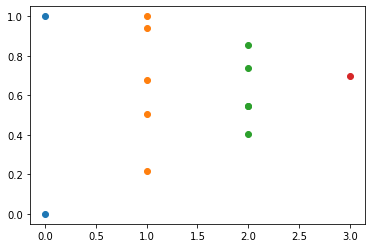

In [13]:
%matplotlib inline
for i, pos in enumerate(positions):
    plt.scatter([i]*len(pos), pos)

In [14]:
del_positions

[array([[0.],
        [1.]]), array([[0.21866497],
        [0.94074695],
        [0.99919202],
        [0.50446593],
        [0.67896137]]), array([[0.85655468],
        [0.54842584],
        [0.7377422 ],
        [0.40548879],
        [0.54814589]]), array([[0.69820355]])]

In [15]:
del_position0

NameError: name 'del_position0' is not defined